# Implementing Logistic Regression

## Abstract

Link to [logistic source code](https://github.com/EpicET/EpicET.github.io/blob/main/posts/blog5/logistic.py).

This notebook implements a logistic regression model with a gradient descent optimizer. The model is trained on a synthetic dataset, and in where it is optimized at each iteration and also updates loss. There are four experiments conducted. The first experiment tested the model on with vanilla gradient descent plotting the loss per iteration and a decision boundary. The second experiment compared the loss per iterations between the model when using the vanilla descent and when using momentum descent. The third experiment was to overfit the model to the training data and compare it to the accuracy of the model on the test data. The fourth experiment was to test the model on a heart disease prediction dateset. The dataset was split into training, validation, and test data.  The model was trained on the training data and the loss computed for both training and validation. The model was then evaluated on the test data, and the accuracy was reported.

In [154]:
%load_ext autoreload
%autoreload 2

from logistic import LogisticRegression, GradientDescentOptimizer
import torch


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
import numpy as np

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)


This code was adapted from previous notes.

In [156]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def plot_classification_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

def draw_line(w, X, y, x_min, x_max, **kwargs):
    fig, ax = plt.subplots(1, 1)
    plot_classification_data(X, y, ax)
    x = torch.linspace(x_min, x_max, 101)
    y = -(w[0]*x + w[2])/w[1]
    l = ax.plot(x, y, **kwargs)

## Experiments

### Experiment 1: Vanilla Logistic Regression


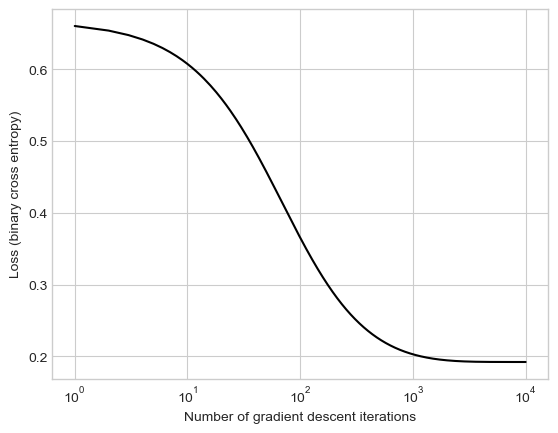

In [157]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec = []

for _ in range(10000):
    loss = LR.loss(X, y) 
    loss_vec.append(loss)
     
    opt.step(X, y, alpha = 0.1, beta = 0)

  
plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black")
plt.semilogx()
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

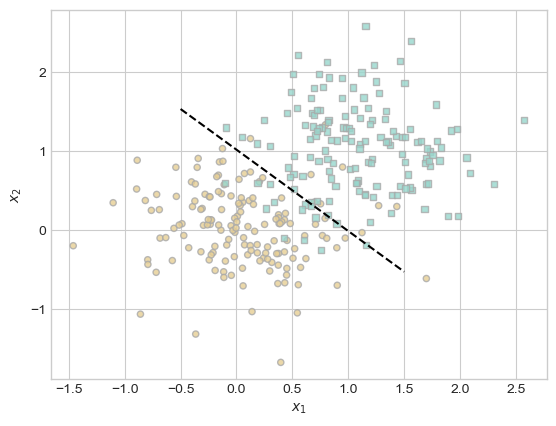

In [158]:
draw_line(opt.model.w, X, y, x_min = -0.5, x_max = 1.5, color = "black", linestyle = "dashed")

The code above implements a vanilla gradient descent with logistic regression. It is run through a training loop, while keeping track of the loss and storing it in an array called loss_vec. Using loss_vec, I plot a graph showing the loss over gradient iterations. The second graph shows the decision boundary of the data. 
- Loss: This appears to hit convergence with a loss <0.2 at ~10,000 iterations. 
- Decision Boundary: The decision boundary appears to correctly classify the data.

### Experiment 2: Benefits of Momentum

In [159]:
X, y = classification_data(n_points=700, noise = 0.1)

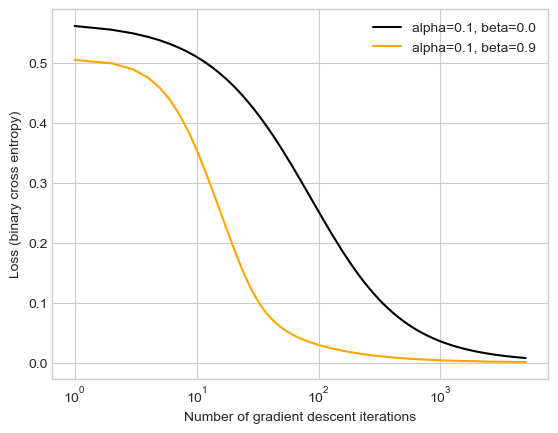

In [160]:
import matplotlib.pyplot as plt
import torch

# Vanilla gradient descent
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec1 = []
iterations = 5000
alpha = 0.1
for _ in range(iterations):
    loss = LR.loss(X, y)
    loss_vec1.append(loss)
    opt.step(X, y, alpha, beta=0.0)  

# Momentum version
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec2 = []
for _ in range(iterations):
    loss = LR.loss(X, y)
    loss_vec2.append(loss)
    opt.step(X, y, alpha, beta=0.9) 


plt.plot(torch.arange(1, len(loss_vec1) + 1), loss_vec1, color="black", label=f"alpha={alpha}, beta=0.0")
plt.plot(torch.arange(1, len(loss_vec2) + 1), loss_vec2, color="orange", label=f"alpha={alpha}, beta=0.9")
plt.semilogx()
plt.xlabel("Number of gradient descent iterations")
plt.ylabel("Loss (binary cross entropy)")
plt.legend()
plt.show()


The code above plots the loss over iterations for both vanilla gradient descent and momentum gradient descent (beta = 0.9) over 5000 iterations with an alpha of 0.1. The loss of both descents begin at ~0.64, but momentum gradient descent drops lower a lot qucker and reaches convergence at ~1000 iterations. Vanilla gradient descent takes ~5000 iterations to reach convergence.

### Experiment 3: Overfitting

In [161]:
X_train, y_train = classification_data(n_points= 60, noise = 0.3, p_dims = 100)
X_test, y_test = classification_data(n_points= 60, noise = 0.3, p_dims = 100)

In [162]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

for _ in range(200): 
    opt.step(X_train, y_train, alpha = 0.01, beta = 0.9)

In [163]:
# Calculate training accuracy
train_predictions = LR.predict(X_train)
train_accuracy = (train_predictions == y_train).float().mean().item()
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Calculate testing accuracy
test_predictions = LR.predict(X_test)
test_accuracy = (test_predictions == y_test).float().mean().item()
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 100.00%
Testing Accuracy: 93.33%


This experiments creates equal data for train and test set with 60 points, 100 dimensions and a noise of 0.3. The model(alpha = 0.01, beta = 0.9) is trained on the training set for 200 iterations,leading to overfitting and a training accuracy of a 100%. The accuracy of the model on the test set is 96.67%, which is rather good given the model was overfitted.

### Experiment 4: Performance ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍on ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍empirical ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data

For my external dataset, I used a [heart prediction dataset](https://www.kaggle.com/datasets/shantanugarg274/heart-prediction-dataset-quantum) from Kaggle. 

In [164]:
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split

# Download dataset from Kaggle
path = kagglehub.dataset_download("shantanugarg274/heart-prediction-dataset-quantum")
print("Path to dataset files:", path)

data_path = path + "/Heart Prediction Quantum Dataset.csv"
df = pd.read_csv(data_path)
# print(df.head())

Path to dataset files: /Users/emmanueltowner/.cache/kagglehub/datasets/shantanugarg274/heart-prediction-dataset-quantum/versions/1


Here I found a dataset on heart disease prediction from Kaggle. The data was in 1 csv file with 7 columns representing age, gender, blood pressure, cholesterol, heart rate, quantum pattern feature, and heart disease. 

In [165]:
X_data = df.drop("HeartDisease", axis=1).values
y_data = df["HeartDisease"].values

Since I intend to predict heart disease, I removed that column from the main dataset in part in the target set.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_data = scaler.fit_transform(X_data)
X_data = torch.tensor(X_data, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32)

The data across features widely varied in range and so I used sci-kit learn's StandardScaler to standardize the both datasets and then converted them into tensors.  The model was trained on the training set and the loss computed for both training and validation. 

In [167]:
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

I also used train_test_split to split the 60% data into training, 20% in validation, and test sets. I had to do this in 2 steps since the you cannot split the data into 3 sets at once. 

Text(0.5, 1.0, 'Validation Loss')

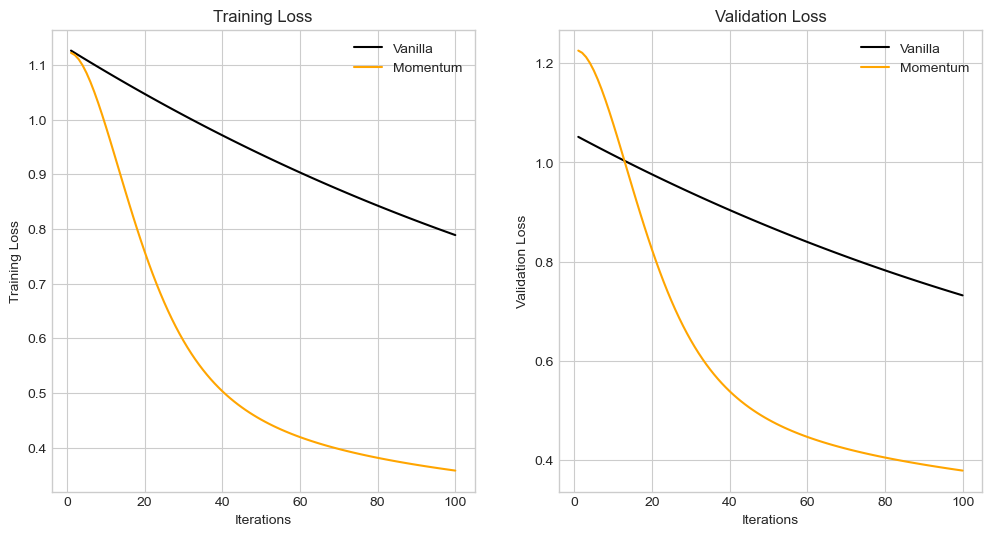

In [168]:
import matplotlib.pyplot as plt
import torch

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Vanilla gradient descent
LRV = LogisticRegression() 
optv = GradientDescentOptimizer(LRV)

v_loss_train = []
v_loss_val = []

iterations = 100
alpha = 0.01
for _ in range(iterations):
    train_loss = LRV.loss(X_train, y_train)
    val_loss = LRV.loss(X_val, y_val)
    v_loss_train.append(train_loss.item())
    v_loss_val.append(val_loss.item())
    optv.step(X_train, y_train, alpha, beta=0.0) 

# Momentum version
LRM = LogisticRegression() 
optm = GradientDescentOptimizer(LRM)

m_loss_train = []
m_loss_val = []
for _ in range(iterations):
    train_loss = LRM.loss(X_train, y_train)
    val_loss = LRM.loss(X_val, y_val)
    m_loss_train.append(train_loss.item())
    m_loss_val.append(val_loss.item())
    optm.step(X_train, y_train, alpha, beta=0.9)  

ax[0].plot(torch.arange(1, iterations + 1), v_loss_train, color="black", label="Vanilla")
ax[0].plot(torch.arange(1, iterations + 1), m_loss_train, color="orange", label="Momentum")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Training Loss")
ax[0].legend()
ax[0].set_title("Training Loss")

ax[1].plot(torch.arange(1, iterations + 1), v_loss_val, color="black", label="Vanilla")
ax[1].plot(torch.arange(1, iterations + 1), m_loss_val, color="orange", label="Momentum")
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Validation Loss")
ax[1].legend()
ax[1].set_title("Validation Loss")


The 2 graphs above show the loss over iterations for both training and validation. The model was trained for 100 iterations with an alpha of 0.01 and mommentum beta of 0.9. The graphs were similar to each other and the only the momentum loss(~0.2 for training and ~0.3 for validation) reached convergence at the end.

In [174]:
test_loss = LRM.loss(X_test, y_test)
print(f"Testing Loss: {test_loss.item():.4f}")

# Testing Accuracy
test_predictions = LRM.predict(X_test)
test_accuracy = (test_predictions == y_test).float().mean().item()
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

Testing Loss: 0.3792
Testing Accuracy: 81.00%


My model had a losss of 0.38 and accuracy of 81% on the test set. While the accuracy is was ok, the loss was a bit high.

## Discussion

In this blog post, I implemented a logistic regression model with a momentum based optimizer. It successfully achieved convergence with vanilla gradient(beta = 0), then proved the with momentum it could increase speedup. The model was able to overfit the training data and achieve a high accuracy on the test set. The model was also able to learn the heart disease dataset, reach convergence, and achieve a good accuracy. The loss was a bit high, but maybe with more iterations it could be improved.
In this blog post, I improved my data preprocesssing skills. I learned the purpose of and how to use sci-kit learn's StandardScaler to standardize features. I gained experience converting the recieved data into a useful data types. As always my graphing skills improved with matplotlib and creating line plots. 